In [5]:
pip install gdelt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.4/787.4 kB 8.4 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Data Collection using GDELT

# Indian company data collection 

In [ ]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta

# Company list with alternatives for better search results (50 unique)
indian_companies = [("Divis Laboratories","Divis Labs"), 
("Reddy Laboratories", "DRREDDY"),
    ("Reliance Industries", "Reliance"),
    ("Tata Consultancy Services", "TCS"),
    ("Infosys", "Infosys"),
    ("HDFC Bank", "HDFC"),
    ("ICICI Bank", "ICICI"),
    ("State Bank of India", "SBI"),
    ("Wipro", "Wipro"),
    ("ITC Limited", "ITC"),
    ("Hindustan Unilever", "HUL"),
    ("Kotak Mahindra Bank", "Kotak"),
    ("Axis Bank", "Axis Bank"),
    ("Larsen and Toubro", "LT"),
    ("Adani Enterprises", "Adani"),
    ("Adani Ports", "Adani Ports"),
    ("Bharti Airtel", "Airtel"),
    ("Bajaj Finance", "Bajaj Finance"),
    ("Bajaj Finserv", "Bajaj Finserv"),
    ("Power Grid Corporation", "Power Grid"),
    ("NTPC", "NTPC"),
    ("ONGC", "ONGC"),
    ("Titan Company", "Titan"),
    ("Sun Pharmaceutical", "Sun Pharma"),
    ("UltraTech Cement", "UltraTech"),
    ("HCL Technologies", "HCL Tech"),
    ("Tech Mahindra", "Tech Mahindra"),
    ("Maruti Suzuki", "Maruti"),
    ("Mahindra and Mahindra", "Mahindra"),
    ("Hero MotoCorp", "Hero"),
    ("Bajaj Auto", "Bajaj Auto"),
    ("Vedanta Limited", "Vedanta"),
    ("Nestle India", "Nestle"),
    ("Asian Paints", "Asian Paints"),
    ("Britannia Industries", "Britannia"),
    ("JSW Steel", "JSW"),
    ("Tata Steel", "Tata Steel"),
    ("Coal India", "Coal India"),
    ("Eicher Motors", "Eicher"),
    ("Grasim Industries", "Grasim"),
    ("Shree Cement", "Shree Cement"),
    ("UPL Limited", "UPL"),
    ("Bharat Petroleum", "BPCL"),
    ("Indian Oil Corporation", "IOC"),
    ("Hindalco Industries", "Hindalco"),
    ("SBI Life Insurance", "SBI Life"),
    ("HDFC Life Insurance", "HDFC Life"),
    ("Apollo Hospitals", "Apollo"),
    ("IndusInd Bank", "IndusInd"),
    ("Bajaj Holdings", "Bajaj Holdings")
]


# ✅ Generate all months for 2024
def generate_month_ranges(year=2024):
    ranges = []
    for month in range(1, 13):
        start = datetime(year, month, 1)
        if month == 12:
            end = datetime(year+1, 1, 1) - timedelta(days=1)
        else:
            end = datetime(year, month+1, 1) - timedelta(days=1)
        ranges.append((start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d"), start.strftime("%B")))
    return ranges

DATE_RANGES = generate_month_ranges(2024)

# Config
DELAY_BETWEEN_REQUESTS = 2
CHECKPOINT_INTERVAL = 10
OUTPUT_FILE = "indian_companies_gdelt_2024.csv"
CHECKPOINT_FILE = "checkpoint_gdelt_2024.csv"

# GDELT DOC 2.0 API endpoint
GDELT_API_URL = "https://api.gdeltproject.org/api/v2/doc/doc"

def search_gdelt_api(query, start_date, end_date, max_records=250):
    clean_query = query.replace('&', 'AND').replace("'", "")
    params = {
        'query': clean_query,
        'mode': 'artlist',
        'maxrecords': max_records,
        'format': 'json',
        'startdatetime': start_date.replace('-', '') + '000000',
        'enddatetime': end_date.replace('-', '') + '235959',
        'sourcelang': 'eng',
    }
    try:
        response = requests.get(GDELT_API_URL, params=params, timeout=30)
        response.raise_for_status()
        if not response.text.strip():
            return []
        data = response.json()
        return data.get('articles', [])
    except Exception:
        return []

all_news, successful_fetches, failed_fetches = [], 0, 0
total_requests = len(indian_companies) * len(DATE_RANGES)
request_count = 0

print(f"📊 Starting GDELT news collection for {len(indian_companies)} companies, year 2024")
print(f"Total API calls planned: {total_requests}")

for month_start, month_end, month_name in DATE_RANGES:
    print(f"\n📅 Processing {month_name} 2024 ({month_start} → {month_end})")
    for company_full, company_short in indian_companies:
        request_count += 1
        print(f"[{request_count}/{total_requests}] {month_name} - {company_full} ...", end=" ")

        articles = search_gdelt_api(company_full, month_start, month_end)
        if not articles and company_short != company_full:
            articles = search_gdelt_api(company_short, month_start, month_end)

        if articles:
            df_articles = pd.DataFrame(articles)
            df_articles['company'] = company_full
            df_articles['search_term'] = company_full if articles else company_short
            df_articles['month'] = month_name
            df_articles['date_range'] = f"{month_start} to {month_end}"
            all_news.append(df_articles)
            successful_fetches += 1
            print(f"✓ {len(articles)} articles")
        else:
            failed_fetches += 1
            print("✗ No results")

        if request_count % CHECKPOINT_INTERVAL == 0 and all_news:
            pd.concat(all_news, ignore_index=True).to_csv(CHECKPOINT_FILE, index=False)
            print(f"  → Checkpoint saved ({len(all_news)} successful fetches)")

        if request_count < total_requests:
            time.sleep(DELAY_BETWEEN_REQUESTS)

print(f"\n✅ Collection finished! Success: {successful_fetches}, Failed: {failed_fetches}")

if all_news:
    df = pd.concat(all_news, ignore_index=True)
    if 'language' in df.columns:
        df = df[df['language'].str.lower().isin(['english', 'eng'])]
    cols = ['company', 'month', 'date_range', 'search_term', 'title', 'seendate', 'url', 'domain']
    df_final = df[[c for c in cols if c in df.columns]]
    df_final.to_csv(OUTPUT_FILE, index=False)
    print(f"\n💾 Data saved to {OUTPUT_FILE} with {len(df_final)} articles")


# US company data collection

In [ ]:
import pandas as pd
import requests
import time
from datetime import datetime
from urllib.parse import quote

# US Company list with alternatives for better search results
us_companies = [  ("Coca-Cola", "Coke"),
    ("Apple Inc", "Apple"),
    ("Microsoft Corporation", "Microsoft"),
    ("Amazon.com", "Amazon"),
    ("Alphabet Inc", "Google"),
    ("Meta Platforms", "Meta"),
    ("Tesla Inc", "Tesla"),
    ("NVIDIA Corporation", "NVIDIA"),
    ("Netflix Inc", "Netflix"),
    ("PayPal Holdings", "PayPal"),
    ("Adobe Inc", "Adobe"),
    ("Intel Corporation", "Intel"),
    ("Advanced Micro Devices", "AMD"),
    ("Cisco Systems", "Cisco"),
    ("Qualcomm Inc", "Qualcomm"),
    ("Texas Instruments", "TI"),
    ("Oracle Corporation", "Oracle"),
    ("Salesforce Inc", "Salesforce"),
    ("IBM", "IBM"),
    ("Shopify Inc", "Shopify"),
    ("Broadcom Inc", "Broadcom"),
    ("JPMorgan Chase", "JPMorgan"),
    ("Bank of America", "BofA"),
    ("Wells Fargo", "Wells Fargo"),
    ("Goldman Sachs", "Goldman"),
    ("Morgan Stanley", "Morgan Stanley"),
    ("Visa Inc", "Visa"),
    ("Mastercard Inc", "Mastercard"),
    ("American Express", "Amex"),
    ("Citigroup Inc", "Citi"),
    ("BlackRock Inc", "BlackRock"),
    ("Walt Disney Company", "Disney"),
    ("PepsiCo Inc", "Pepsi"),
    ("McDonald's Corporation", "McDonalds"),
    ("Nike Inc", "Nike"),
    ("Walmart Inc", "Walmart"),
    ("Costco Wholesale", "Costco"),
    ("Target Corporation", "Target"),
    ("Home Depot", "Home Depot"),
    ("Procter and Gamble", "P&G"),
    ("UnitedHealth Group", "UnitedHealth"),
    ("Pfizer Inc", "Pfizer"),
    ("Johnson and Johnson", "J&J"),
    ("Merck and Co", "Merck"),
    ("AbbVie Inc", "AbbVie"),
    ("Chevron Corporation", "Chevron"),
    ("Exxon Mobil", "Exxon"),
    ("ConocoPhillips", "ConocoPhillips"),
    ("Schlumberger", "SLB"),
    ("Occidental Petroleum", "Oxy")
]

# Date ranges for Q1 2024 (January, February, March)
# Date ranges for full year 2024
DATE_RANGES = [
    ("2024-01-01", "2024-01-31", "January"),
    ("2024-02-01", "2024-02-29", "February"),
    ("2024-03-01", "2024-03-31", "March"),
    ("2024-04-01", "2024-04-30", "April"),
    ("2024-05-01", "2024-05-31", "May"),
    ("2024-06-01", "2024-06-30", "June"),
    ("2024-07-01", "2024-07-31", "July"),
    ("2024-08-01", "2024-08-31", "August"),
    ("2024-09-01", "2024-09-30", "September"),
    ("2024-10-01", "2024-10-31", "October"),
    ("2024-11-01", "2024-11-30", "November"),
    ("2024-12-01", "2024-12-31", "December")
]


# Configuration
DELAY_BETWEEN_REQUESTS = 2  # seconds (be respectful to the API)
CHECKPOINT_INTERVAL = 10
OUTPUT_FILE = "us_companies_gdelt_q1_2024_english.csv"
CHECKPOINT_FILE = "checkpoint_us_gdelt_q1.csv"

# GDELT DOC 2.0 API endpoint
GDELT_API_URL = "https://api.gdeltproject.org/api/v2/doc/doc"

def search_gdelt_api(query, start_date, end_date, max_records=250):
    """
    Search GDELT using their DOC 2.0 API for English articles only
    """
    # Clean query - replace special characters that might cause issues
    clean_query = query.replace('&', 'AND').replace("'", "")
    
    params = {
        'query': clean_query,
        'mode': 'artlist',
        'maxrecords': max_records,
        'format': 'json',
        'startdatetime': start_date.replace('-', '') + '000000',
        'enddatetime': end_date.replace('-', '') + '235959',
        'sourcelang': 'eng',  # Filter for English language only
    }
    
    try:
        response = requests.get(GDELT_API_URL, params=params, timeout=30)
        response.raise_for_status()
        
        # Check if response has content
        if not response.text or response.text.strip() == '':
            return []
        
        data = response.json()
        
        if 'articles' in data:
            return data['articles']
        return []
    except requests.exceptions.JSONDecodeError:
        # API returned empty or invalid JSON - likely no results
        return []
    except requests.exceptions.RequestException as e:
        raise Exception(f"Request error: {e}")
    except Exception as e:
        raise Exception(f"API error: {e}")

all_news = []
successful_fetches = 0
failed_fetches = 0
total_requests = len(us_companies) * len(DATE_RANGES)
gdelt_columns_printed = False  # Flag to print columns only once

print(f"Starting GDELT news collection for {len(us_companies)} US companies")
print(f"Date ranges: Q1 2024 (Jan, Feb, Mar)")
print(f"Language filter: English only")
print(f"Total API calls: {total_requests}")
print(f"Using GDELT DOC 2.0 API")
print(f"{'='*70}\n")

request_count = 0

for month_start, month_end, month_name in DATE_RANGES:
    print(f"\n📅 Processing {month_name} 2024 ({month_start} to {month_end})")
    print(f"{'-'*70}")
    
    for idx, (company_full, company_short) in enumerate(us_companies, 1):
        request_count += 1
        try:
            print(f"[{request_count}/{total_requests}] {month_name} - '{company_full}'...", end=" ")
            
            # Try with full name first
            articles = search_gdelt_api(company_full, month_start, month_end)
            
            # If no results with full name, try short name
            if not articles and company_short != company_full:
                articles = search_gdelt_api(company_short, month_start, month_end)
                if articles:
                    print(f"(used '{company_short}') ", end="")
            
            if articles:
                # Convert to DataFrame
                df_articles = pd.DataFrame(articles)
                
                # Print available GDELT columns (only once)
                if not gdelt_columns_printed:
                    print(f"\n{'='*70}")
                    print(f"📋 Available GDELT API Columns ({len(df_articles.columns)} total):")
                    print(f"{'='*70}")
                    for i, col in enumerate(df_articles.columns, 1):
                        print(f"{i:2d}. {col}")
                    print(f"{'='*70}\n")
                    gdelt_columns_printed = True
                
                df_articles['company'] = company_full
                df_articles['search_term'] = company_short if not articles else company_full
                df_articles['month'] = month_name
                df_articles['date_range'] = f"{month_start} to {month_end}"
                all_news.append(df_articles)
                successful_fetches += 1
                print(f"✓ {len(articles)} articles")
            else:
                failed_fetches += 1
                print(f"✗ No results")
            
            # Save checkpoint periodically
            if len(all_news) > 0 and request_count % CHECKPOINT_INTERVAL == 0:
                checkpoint_df = pd.concat(all_news, ignore_index=True)
                checkpoint_df.to_csv(CHECKPOINT_FILE, index=False)
                print(f"  → Checkpoint saved ({len(all_news)} successful fetches)")
            
            # Rate limiting delay
            if request_count < total_requests:
                time.sleep(DELAY_BETWEEN_REQUESTS)
                
        except Exception as e:
            failed_fetches += 1
            print(f"✗ Error: {e}")

print(f"\n{'='*70}")
print(f"Collection completed!")
print(f"Successful: {successful_fetches} | Failed: {failed_fetches}")

# Combine and save results
if all_news:
    df = pd.concat(all_news, ignore_index=True)
    
    # Filter for English titles only (additional safety check)
    if 'language' in df.columns:
        initial_count = len(df)
        # Check for multiple possible English language formats
        df = df[df['language'].str.lower().isin(['english', 'eng'])]
        filtered_count = initial_count - len(df)
        if filtered_count > 0:
            print(f"\n🔍 Filtered out {filtered_count} non-English articles")
        else:
            print(f"\n✓ All {initial_count} articles are in English")
    else:
        print(f"\n⚠️  No 'language' column found - relying on API filter only")
    
    # Select relevant columns if they exist
    # Based on actual GDELT DOC API response
    possible_cols = [
        'company', 'month', 'date_range', 'search_term',
        'title', 'seendate', 'url', 'url_mobile', 
        'domain', 'language', 'socialimage', 'sourcecountry'
    ]
    available_cols = [col for col in possible_cols if col in df.columns]
    
    if available_cols:
        df_final = df[available_cols]
    else:
        df_final = df
    
    # Save final output
    df_final.to_csv(OUTPUT_FILE, index=False)
    
    print(f"\n✅ Data saved to {OUTPUT_FILE}")
    print(f"Total English articles collected: {len(df_final):,}")
    print(f"Columns: {list(df_final.columns)}")
    
    # Summary statistics
    if 'company' in df_final.columns:
        print(f"\nTop 10 companies by article count:")
        print(df_final['company'].value_counts().head(10))
    
    if 'month' in df_final.columns:
        print(f"\nArticles by month:")
        print(df_final['month'].value_counts().sort_index())
else:
    print("\n⚠️  No data collected.")
    
print(f"\nScript completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Merge Indian and US company data into one dataset

In [1]:
import pandas as pd
from datetime import datetime

# ============================================================
# 📊 DATA MERGING & PREPARATION FOR SENTIMENT ANALYSIS (Optimized)
# ============================================================

def load_dataset(path, label):
    """Load CSV with error handling and add market column."""
    try:
        df = pd.read_csv(path)
        print(f"✅ {label}: {len(df):,} articles | Columns: {len(df.columns)}")
        df['market'] = label
        return df
    except Exception as e:
        print(f"❌ Failed to load {label}: {e}")
        return pd.DataFrame()

def ensure_columns(df, required_cols, default_map):
    """Ensure dataset has required + optional columns with defaults."""
    for col, default in default_map.items():
        if col not in df.columns:
            df[col] = default
    for col in required_cols:
        if col not in df.columns:
            df[col] = None
    return df

def clean_and_filter(df):
    """Clean, filter to 2024, and prepare features."""
    # Drop rows missing critical info
    df = df.dropna(subset=['company', 'title', 'seendate', 'url'])
    
    # Deduplicate on URL
    df = df.drop_duplicates(subset=['url'], keep='first')
    
    # Parse date
    df['date'] = pd.to_datetime(df['seendate'], format='%Y%m%dT%H%M%SZ', errors='coerce')
    df = df.dropna(subset=['date'])
    
    # Filter strictly to 2024
    df = df[(df['date'].dt.year == 2024)].copy()
    
    # Add date breakdown
    df['date_only'] = df['date'].dt.date
    df['year'] = df['date'].dt.year
    df['month_num'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.day_name()
    
    # Clean titles
    df['title'] = df['title'].astype(str).str.strip()
    df['title_length'] = df['title'].str.len()
    df = df[df['title_length'] >= 10]  # remove too short
    
    return df

def print_summary(df):
    """Print key statistics."""
    print("\n📊 Summary Statistics")
    print("="*50)
    print(f"Total articles: {len(df):,}")
    print(f"Total companies: {df['company'].nunique()}")
    print(f"Markets: {df['market'].value_counts().to_dict()}")
    print(f"Date range: {df['date_only'].min()} → {df['date_only'].max()}")
    print(f"Days covered: {df['date_only'].nunique()}")
    
    print("\n🏢 Top 10 Companies:")
    print(df['company'].value_counts().head(10))
    
    print("\n📰 Top 5 News Sources:")
    print(df['domain'].value_counts().head(5))
    
    print("\n📅 Articles by Month:")
    print(df['month_num'].value_counts().sort_index())

# ============================================================
# 1. Load Datasets
# ============================================================

print("\n1️⃣ Loading datasets...")
indian_df = load_dataset("/kaggle/input/sentiment-data-from-gdelt/indian_companies_gdelt_2024.csv", "Indian")
us_df = load_dataset("/kaggle/input/sentiment-data-from-gdelt/us_companies_gdelt_q1_2024_english.csv", "US")

# ============================================================
# 2. Standardize Columns
# ============================================================

essential_cols = ['company','title','seendate','url','month','date_range','search_term','domain']
optional_cols = {'url_mobile': None, 'language': 'English', 'socialimage': None, 'sourcecountry': None}

indian_df = ensure_columns(indian_df, essential_cols, optional_cols)
us_df = ensure_columns(us_df, essential_cols, optional_cols)

# Align final column order
final_cols = essential_cols + ['market'] + list(optional_cols.keys())
indian_df, us_df = indian_df[final_cols], us_df[final_cols]

# ============================================================
# 3. Merge & Clean
# ============================================================

print("\n2️⃣ Cleaning datasets...")
combined_df = pd.concat([indian_df, us_df], ignore_index=True)
combined_df = clean_and_filter(combined_df)

# ============================================================
# 4. Stats & Save
# ============================================================

print_summary(combined_df)

# Save final cleaned dataset
output_file = "merged_news_data_cleaned.csv"
combined_df.to_csv(output_file, index=False)
print(f"\n✅ Final dataset saved → {output_file}")



1️⃣ Loading datasets...
✅ Indian: 98,786 articles | Columns: 8
✅ US: 118,462 articles | Columns: 12

2️⃣ Cleaning datasets...

📊 Summary Statistics
Total articles: 162,444
Total companies: 100
Markets: {'US': 106419, 'Indian': 56025}
Date range: 2024-01-01 → 2024-12-31
Days covered: 366

🏢 Top 10 Companies:
company
Meta Platforms        2868
UnitedHealth Group    2842
BlackRock Inc         2781
Alphabet Inc          2765
Cisco Systems         2742
Netflix Inc           2733
Bank of America       2695
Walmart Inc           2686
Pfizer Inc            2685
Costco Wholesale      2671
Name: count, dtype: int64

📰 Top 5 News Sources:
domain
economictimes.indiatimes.com    7332
theenterpriseleader.com         6552
themarketsdaily.com             6517
wkrb13.com                      6511
modernreaders.com               5198
Name: count, dtype: int64

📅 Articles by Month:
month_num
1     13594
2     13600
3     13944
4     14307
5     13669
6     13944
7     13790
8     13386
9     14078
10   

In [ ]:
pip install transformers torch tqdm


In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("📊 FINBERT SENTIMENT ANALYSIS (Optimized + Aggregation)")
print("="*70)

# ------------------------------
# 1️⃣ Load merged news dataset
# ------------------------------
print("\nLoading merged data...")
df = pd.read_csv("/kaggle/working/merged_news_data_cleaned.csv")
print(f"✅ Loaded {len(df):,} articles")
print(f"   Companies: {df['company'].nunique()}")
print(f"   Markets: {df['market'].value_counts().to_dict()}")

# Ensure date column
df['date_only'] = pd.to_datetime(df['date_only'], errors='coerce')
df = df.dropna(subset=['date_only'])

# ------------------------------
# 2️⃣ Load FinBERT model
# ------------------------------
print("\nLoading FinBERT model...")
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
labels = ["positive", "negative", "neutral"]
print(f"✅ Model loaded on: {device}")

# ------------------------------
# 3️⃣ Batched sentiment analysis
# ------------------------------
def analyze_batch(texts, max_length=128):
    """Run FinBERT sentiment analysis on a batch of texts."""
    texts = [str(t) if pd.notna(t) else "neutral text" for t in texts]
    texts = ["neutral text" if len(t.strip())==0 else t for t in texts]

    inputs = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

    sentiments, confidences, scores = [], [], []
    for p in probs:
        idx = np.argmax(p)
        sentiments.append(labels[idx])
        confidences.append(float(p[idx]))
        scores.append(float(p[0] - p[1]))  # positive - negative

    return sentiments, confidences, scores

print("\nAnalyzing sentiment in batches...")
batch_size = 64
all_sentiments, all_confidences, all_scores = [], [], []

for i in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
    batch_texts = df['title'].iloc[i:i+batch_size].tolist()
    sents, confs, scs = analyze_batch(batch_texts)
    all_sentiments.extend(sents)
    all_confidences.extend(confs)
    all_scores.extend(scs)

# Attach sentiment results
df['sentiment'] = all_sentiments
df['sentiment_confidence'] = all_confidences
df['sentiment_score'] = all_scores

print("\n✅ Sentiment analysis complete!")

# ------------------------------
# 4️⃣ Quick sentiment stats
# ------------------------------
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())
print(f"Positive: {(df['sentiment']=='positive').mean()*100:.1f}%")
print(f"Negative: {(df['sentiment']=='negative').mean()*100:.1f}%")
print(f"Neutral:  {(df['sentiment']=='neutral').mean()*100:.1f}%")
print(f"Average Confidence: {df['sentiment_confidence'].mean():.3f}")
print(f"Average Sentiment Score: {df['sentiment_score'].mean():.3f}")

# ------------------------------
# 5️⃣ Aggregate Daily Sentiment
# ------------------------------
print("\nAggregating daily sentiment per company...")
daily_sentiment = df.groupby(['company', 'market', 'date_only']).agg(
    avg_sentiment=('sentiment_score', 'mean'),
    sentiment_std=('sentiment_score', 'std'),
    article_count=('sentiment_score', 'count'),
    positive_ratio=('sentiment', lambda x: (x=='positive').mean())
).reset_index()
daily_sentiment['sentiment_std'] = daily_sentiment['sentiment_std'].fillna(0)

print(f"✅ Daily sentiment aggregated: {len(daily_sentiment)} records")

# ------------------------------
# 6️⃣ Aggregate Monthly Sentiment
# ------------------------------
print("\nAggregating monthly sentiment per company...")
df['month'] = df['date_only'].dt.to_period('M')
monthly_sentiment = df.groupby(['company', 'market', 'month']).agg(
    avg_sentiment=('sentiment_score', 'mean'),
    sentiment_std=('sentiment_score', 'std'),
    article_count=('sentiment_score', 'count'),
    positive_ratio=('sentiment', lambda x: (x=='positive').mean())
).reset_index()
monthly_sentiment['sentiment_std'] = monthly_sentiment['sentiment_std'].fillna(0)

print(f"✅ Monthly sentiment aggregated: {len(monthly_sentiment)} records")

# ------------------------------
# 7️⃣ Save Results
# ------------------------------
df.to_csv("news_with_sentiment.csv", index=False)
daily_sentiment.to_csv("daily_sentiment_scores.csv", index=False)
monthly_sentiment.to_csv("monthly_sentiment_scores.csv", index=False)

print("\n✅ Files saved:")
print(" - news_with_sentiment.csv        (article-level)")
print(" - daily_sentiment_scores.csv     (daily aggregated)")
print(" - monthly_sentiment_scores.csv   (monthly aggregated)")


📊 FINBERT SENTIMENT ANALYSIS (Optimized + Aggregation)

Loading merged data...
✅ Loaded 162,444 articles
   Companies: 100
   Markets: {'US': 106419, 'Indian': 56025}

Loading FinBERT model...


2025-10-05 17:26:22.246499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759685182.444989      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759685182.498867      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Model loaded on: cuda

Analyzing sentiment in batches...



Processing batches: 100%|██████████| 2539/2539 [03:15<00:00, 13.01it/s]



✅ Sentiment analysis complete!

Sentiment Distribution:
sentiment
neutral     100238
positive     33824
negative     28382
Name: count, dtype: int64
Positive: 20.8%
Negative: 17.5%
Neutral:  61.7%
Average Confidence: 0.845
Average Sentiment Score: 0.047

Aggregating daily sentiment per company...
✅ Daily sentiment aggregated: 30096 records

Aggregating monthly sentiment per company...
✅ Monthly sentiment aggregated: 1200 records

✅ Files saved:
 - news_with_sentiment.csv        (article-level)
 - daily_sentiment_scores.csv     (daily aggregated)
 - monthly_sentiment_scores.csv   (monthly aggregated)


# Performance metric - Training Phase

📊 SENTIMENT ANALYSIS PERFORMANCE METRICS

✅ Loaded 162,444 articles with sentiment scores

📈 SENTIMENT DISTRIBUTION

Positive: 33,824 (20.8%)
Negative: 28,382 (17.5%)
Neutral:  100,238 (61.7%)

🎯 CONFIDENCE METRICS

Confidence by Sentiment:
            mean    std    min    max
sentiment                            
negative   0.834  0.146  0.340  0.976
neutral    0.862  0.112  0.349  0.958
positive   0.803  0.140  0.337  0.962

Overall Average Confidence: 0.845
Low Confidence (<0.6): 12,793 articles (7.9%)
High Confidence (>0.9): 81,584 articles (50.2%)

📊 SENTIMENT SCORE DISTRIBUTION

Mean Score: +0.047
Std Dev:    0.501
Min Score:  -0.969
Max Score:  +0.946
Median:     +0.029

Quartiles:
  25th: -0.031
  50th: +0.029
  75th: +0.234

🏢 COMPANY-LEVEL SENTIMENT

Top 5 Most Positive Companies:
                    Avg_Score  Std_Score  Articles  Avg_Confidence
company                                                           
Sun Pharmaceutical      0.306      0.550       535           0.

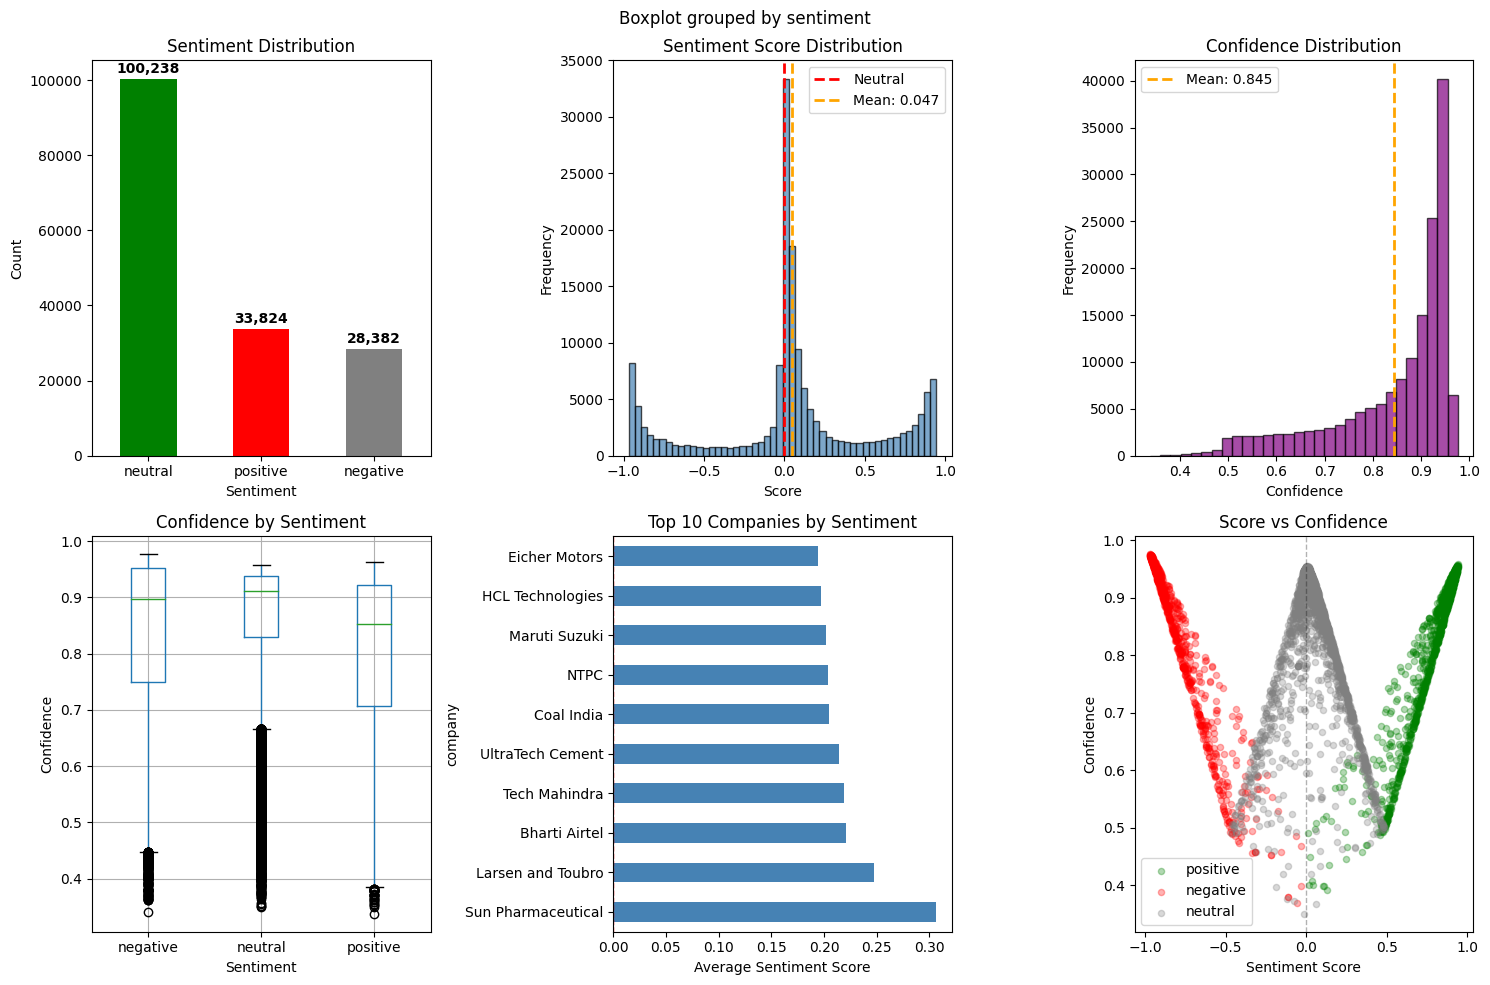


📅 TEMPORAL TRENDS

Date Range: 2024-01-01 to 2024-12-31
Total Days: 366


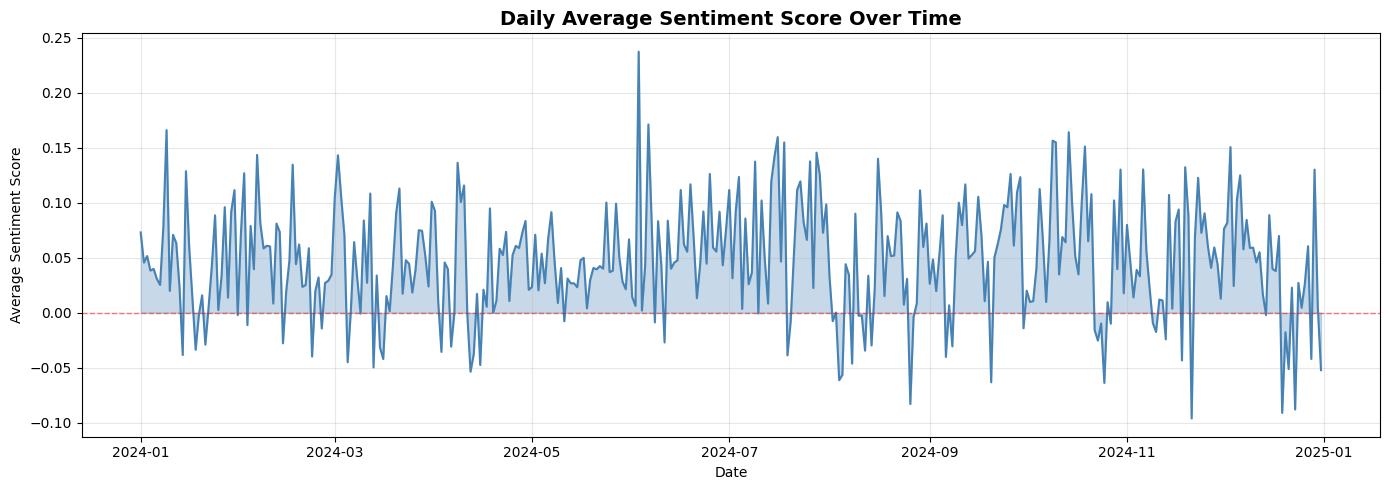


✅ DATA QUALITY METRICS

Total Articles: 162,444
Missing Sentiments: 0
Missing Scores: 0
Missing Confidence: 0

Sentiment Balance:
  Imbalance Ratio: 3.53:1
  ⚠️  Warning: High class imbalance detected!

✅ ANALYSIS COMPLETE!


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("📊 SENTIMENT ANALYSIS PERFORMANCE METRICS")
print("="*70)

# Load the sentiment results
df = pd.read_csv("/kaggle/input/news-with-sentiment/news_with_sentiment.csv")
print(f"\n✅ Loaded {len(df):,} articles with sentiment scores")

# ==================== 1. BASIC STATISTICS ====================
print("\n" + "="*70)
print("📈 SENTIMENT DISTRIBUTION")
print("="*70)

sentiment_counts = df['sentiment'].value_counts()
sentiment_pcts = df['sentiment'].value_counts(normalize=True) * 100

print(f"\nPositive: {sentiment_counts.get('positive', 0):,} ({sentiment_pcts.get('positive', 0):.1f}%)")
print(f"Negative: {sentiment_counts.get('negative', 0):,} ({sentiment_pcts.get('negative', 0):.1f}%)")
print(f"Neutral:  {sentiment_counts.get('neutral', 0):,} ({sentiment_pcts.get('neutral', 0):.1f}%)")

# ==================== 2. CONFIDENCE METRICS ====================
print("\n" + "="*70)
print("🎯 CONFIDENCE METRICS")
print("="*70)

conf_stats = df.groupby('sentiment')['sentiment_confidence'].agg(['mean', 'std', 'min', 'max'])
print("\nConfidence by Sentiment:")
print(conf_stats.round(3))

print(f"\nOverall Average Confidence: {df['sentiment_confidence'].mean():.3f}")
print(f"Low Confidence (<0.6): {(df['sentiment_confidence'] < 0.6).sum():,} articles ({(df['sentiment_confidence'] < 0.6).mean()*100:.1f}%)")
print(f"High Confidence (>0.9): {(df['sentiment_confidence'] > 0.9).sum():,} articles ({(df['sentiment_confidence'] > 0.9).mean()*100:.1f}%)")

# ==================== 3. SENTIMENT SCORE ANALYSIS ====================
print("\n" + "="*70)
print("📊 SENTIMENT SCORE DISTRIBUTION")
print("="*70)

print(f"\nMean Score: {df['sentiment_score'].mean():+.3f}")
print(f"Std Dev:    {df['sentiment_score'].std():.3f}")
print(f"Min Score:  {df['sentiment_score'].min():+.3f}")
print(f"Max Score:  {df['sentiment_score'].max():+.3f}")
print(f"Median:     {df['sentiment_score'].median():+.3f}")

quartiles = df['sentiment_score'].quantile([0.25, 0.5, 0.75])
print(f"\nQuartiles:")
print(f"  25th: {quartiles[0.25]:+.3f}")
print(f"  50th: {quartiles[0.50]:+.3f}")
print(f"  75th: {quartiles[0.75]:+.3f}")

# ==================== 4. COMPANY-LEVEL METRICS ====================
print("\n" + "="*70)
print("🏢 COMPANY-LEVEL SENTIMENT")
print("="*70)

company_stats = df.groupby('company').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'sentiment_confidence': 'mean'
}).round(3)

company_stats.columns = ['Avg_Score', 'Std_Score', 'Articles', 'Avg_Confidence']
company_stats = company_stats.sort_values('Avg_Score', ascending=False)

print("\nTop 5 Most Positive Companies:")
print(company_stats.head())

print("\nTop 5 Most Negative Companies:")
print(company_stats.tail())

# ==================== 5. MARKET-LEVEL METRICS ====================
if 'market' in df.columns:
    print("\n" + "="*70)
    print("🌍 MARKET-LEVEL SENTIMENT")
    print("="*70)
    
    market_stats = df.groupby('market').agg({
        'sentiment_score': 'mean',
        'sentiment_confidence': 'mean',
        'sentiment': 'count'
    }).round(3)
    market_stats.columns = ['Avg_Score', 'Avg_Confidence', 'Articles']
    market_stats = market_stats.sort_values('Avg_Score', ascending=False)
    print(market_stats)

# ==================== 6. VISUALIZATIONS ====================
print("\n" + "="*70)
print("📊 GENERATING VISUALIZATIONS...")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sentiment Analysis Performance Metrics', fontsize=16, fontweight='bold')

# Plot 1: Sentiment Distribution
ax1 = axes[0, 0]
sentiment_counts.plot(kind='bar', ax=ax1, color=['green', 'red', 'gray'])
ax1.set_title('Sentiment Distribution')
ax1.set_ylabel('Count')
ax1.set_xlabel('Sentiment')
ax1.tick_params(axis='x', rotation=0)
for i, v in enumerate(sentiment_counts):
    ax1.text(i, v + len(df)*0.01, f'{v:,}', ha='center', fontweight='bold')

# Plot 2: Sentiment Score Distribution
ax2 = axes[0, 1]
ax2.hist(df['sentiment_score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
ax2.axvline(df['sentiment_score'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {df["sentiment_score"].mean():.3f}')
ax2.set_title('Sentiment Score Distribution')
ax2.set_xlabel('Score')
ax2.set_ylabel('Frequency')
ax2.legend()

# Plot 3: Confidence Distribution
ax3 = axes[0, 2]
ax3.hist(df['sentiment_confidence'], bins=30, color='purple', edgecolor='black', alpha=0.7)
ax3.axvline(df['sentiment_confidence'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {df["sentiment_confidence"].mean():.3f}')
ax3.set_title('Confidence Distribution')
ax3.set_xlabel('Confidence')
ax3.set_ylabel('Frequency')
ax3.legend()

# Plot 4: Confidence by Sentiment
ax4 = axes[1, 0]
df.boxplot(column='sentiment_confidence', by='sentiment', ax=ax4)
ax4.set_title('Confidence by Sentiment')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Confidence')
plt.sca(ax4)
plt.xticks(rotation=0)

# Plot 5: Top 10 Companies by Avg Score
ax5 = axes[1, 1]
top10 = company_stats.head(10)['Avg_Score']
top10.plot(kind='barh', ax=ax5, color='steelblue')
ax5.set_title('Top 10 Companies by Sentiment')
ax5.set_xlabel('Average Sentiment Score')
ax5.axvline(0, color='red', linestyle='--', linewidth=1)

# Plot 6: Score vs Confidence Scatter
ax6 = axes[1, 2]
sample = df.sample(min(5000, len(df)))  # Sample for performance
colors = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
for sentiment in colors:
    mask = sample['sentiment'] == sentiment
    ax6.scatter(sample[mask]['sentiment_score'], 
               sample[mask]['sentiment_confidence'],
               alpha=0.3, s=20, c=colors[sentiment], label=sentiment)
ax6.set_title('Score vs Confidence')
ax6.set_xlabel('Sentiment Score')
ax6.set_ylabel('Confidence')
ax6.legend()
ax6.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.3)

plt.tight_layout()
plt.show()

# ==================== 7. TEMPORAL ANALYSIS ====================
if 'date_only' in df.columns:
    print("\n" + "="*70)
    print("📅 TEMPORAL TRENDS")
    print("="*70)
    
    df['date_only'] = pd.to_datetime(df['date_only'])
    daily_avg = df.groupby('date_only')['sentiment_score'].mean()
    
    print(f"\nDate Range: {df['date_only'].min().date()} to {df['date_only'].max().date()}")
    print(f"Total Days: {len(daily_avg)}")
    
    plt.figure(figsize=(14, 5))
    plt.plot(daily_avg.index, daily_avg.values, linewidth=1.5, color='steelblue')
    plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.fill_between(daily_avg.index, daily_avg.values, 0, alpha=0.3, color='steelblue')
    plt.title('Daily Average Sentiment Score Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==================== 8. QUALITY METRICS ====================
print("\n" + "="*70)
print("✅ DATA QUALITY METRICS")
print("="*70)

print(f"\nTotal Articles: {len(df):,}")
print(f"Missing Sentiments: {df['sentiment'].isna().sum():,}")
print(f"Missing Scores: {df['sentiment_score'].isna().sum():,}")
print(f"Missing Confidence: {df['sentiment_confidence'].isna().sum():,}")

print(f"\nSentiment Balance:")
max_class = sentiment_counts.max()
min_class = sentiment_counts.min()
imbalance_ratio = max_class / min_class if min_class > 0 else float('inf')
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("  ⚠️  Warning: High class imbalance detected!")
else:
    print("  ✅ Sentiment classes are reasonably balanced")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print("="*70)

# Live NewsAPI Testing

In [25]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings('ignore')

"""
SMART LIVE SENTIMENT ANALYSIS
- Tries TODAY's news first
- Falls back to RECENT news (last 7 days) if nothing today
- Shows results immediately
- Perfect for demo and testing
"""

# ==================== CONFIGURATION ====================

NEWS_API_KEY = "c2f8feeb7ff8493faa58ff9c60579890"  # Get from https://newsapi.org/

# Select companies for demo (3-5 recommended for quick test)
TEST_COMPANIES = {
    "Apple": "Apple Inc OR AAPL",
    "Tesla": "Tesla OR TSLA OR Elon Musk",
    "Microsoft": "Microsoft OR MSFT",
    "Google": "Google OR Alphabet OR GOOGL",
    "Amazon": "Amazon OR AMZN"
}

MAX_ARTICLES_PER_COMPANY = 5

# ==================== SETUP ====================

print("="*80)
print("🚀 SMART SENTIMENT ANALYSIS - TODAY'S + RECENT NEWS")
print("="*80)
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🏢 Companies: {len(TEST_COMPANIES)}")
print("="*80)

# Initialize FinBERT
print("\n⏳ Loading FinBERT model...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print(f"✅ Model loaded on: {device}")

# Sentiment labels
labels = ['positive', 'negative', 'neutral']

def analyze_sentiment(text):
    """Analyze sentiment using FinBERT"""
    if not text or len(str(text).strip()) == 0:
        return 'neutral', 0.0, 0.0
    
    inputs = tokenizer(str(text), return_tensors="pt", truncation=True, 
                      max_length=512, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    probs = predictions[0].cpu().numpy()
    sentiment_idx = probs.argmax()
    sentiment_label = labels[sentiment_idx]
    confidence = probs[sentiment_idx]
    sentiment_score = float(probs[0] - probs[1])  # positive - negative
    
    return sentiment_label, float(confidence), sentiment_score

def fetch_news_with_fallback(company_name, query, api_key, max_articles=5):
    """
    Smart fetch: Try today first, then fall back to recent news (last 7 days)
    Returns: (articles, date_range_used)
    """
    today = datetime.now()
    
    # Try 1: Today's news
    from_date = today.strftime('%Y-%m-%d')
    to_date = today.strftime('%Y-%m-%d')
    
    articles = fetch_news(query, from_date, to_date, api_key, max_articles)
    
    if articles:
        return articles, "today"
    
    # Try 2: Last 7 days
    from_date = (today - timedelta(days=7)).strftime('%Y-%m-%d')
    to_date = today.strftime('%Y-%m-%d')
    
    articles = fetch_news(query, from_date, to_date, api_key, max_articles)
    
    if articles:
        return articles, "last 7 days"
    
    return [], "none"

def fetch_news(query, from_date, to_date, api_key, max_articles=5):
    """Fetch news for given date range"""
    params = {
        'q': query,
        'from': from_date,
        'to': to_date,
        'language': 'en',
        'sortBy': 'publishedAt',
        'pageSize': max_articles,
        'apiKey': api_key
    }
    
    try:
        response = requests.get(
            "https://newsapi.org/v2/everything",
            params=params,
            timeout=10
        )
        response.raise_for_status()
        data = response.json()
        
        if data['status'] == 'ok':
            return data.get('articles', [])
        return []
    except Exception as e:
        print(f"   ❌ Error: {e}")
        return []

# ==================== COLLECT & ANALYZE ====================

print("\n" + "="*80)
print("📰 FETCHING & ANALYZING NEWS (SMART MODE)")
print("="*80)

all_results = []

for idx, (company, query) in enumerate(TEST_COMPANIES.items(), 1):
    print(f"\n[{idx}/{len(TEST_COMPANIES)}] {company}")
    print("-"*80)
    
    # Fetch news with smart fallback
    print("   📡 Fetching articles...", end=" ")
    articles, date_range = fetch_news_with_fallback(
        company, query, NEWS_API_KEY, MAX_ARTICLES_PER_COMPANY
    )
    
    if not articles:
        print("❌ No articles found (tried today + last 7 days)")
        continue
    
    # Show what we found
    range_emoji = "📅" if date_range == "today" else "📆"
    print(f"✅ Found {len(articles)} articles ({range_emoji} {date_range})")
    
    # Analyze each article
    company_sentiments = []
    
    for i, article in enumerate(articles, 1):
        title = article.get('title', '')
        description = article.get('description', '')
        source = article.get('source', {}).get('name', 'Unknown')
        url = article.get('url', '')
        published = article.get('publishedAt', '')
        
        # Combine title + description for better analysis
        text = f"{title} {description}"
        
        # Analyze sentiment
        sentiment, confidence, score = analyze_sentiment(text)
        
        # Store result
        result = {
            'company': company,
            'title': title,
            'source': source,
            'url': url,
            'published': published,
            'sentiment': sentiment,
            'confidence': confidence,
            'score': score,
            'date_range': date_range
        }
        all_results.append(result)
        company_sentiments.append(score)
        
        # Display result
        sentiment_emoji = {
            'positive': '🟢',
            'negative': '🔴',
            'neutral': '⚪'
        }
        
        print(f"\n   [{i}] {sentiment_emoji[sentiment]} {sentiment.upper()}")
        print(f"       Score: {score:+.3f} | Confidence: {confidence:.3f}")
        print(f"       Title: {title[:70]}...")
        print(f"       Source: {source}")
        
        # Show how old the article is
        try:
            pub_date = datetime.strptime(published[:10], '%Y-%m-%d')
            days_ago = (datetime.now() - pub_date).days
            if days_ago == 0:
                time_str = "Today"
            elif days_ago == 1:
                time_str = "Yesterday"
            else:
                time_str = f"{days_ago} days ago"
            print(f"       Published: {time_str} ({published[:10]})")
        except:
            print(f"       Published: {published}")
    
    # Company summary
    if company_sentiments:
        avg_sentiment = sum(company_sentiments) / len(company_sentiments)
        positive_count = sum(1 for s in company_sentiments if s > 0)
        negative_count = sum(1 for s in company_sentiments if s < 0)
        
        print(f"\n   📊 {company} Summary:")
        print(f"       Average Sentiment: {avg_sentiment:+.3f}")
        print(f"       Positive: {positive_count} | Negative: {negative_count}")

# ==================== OVERALL SUMMARY ====================

if all_results:
    print("\n" + "="*80)
    print("📊 OVERALL SENTIMENT SUMMARY")
    print("="*80)
    
    df = pd.DataFrame(all_results)
    
    # Show data freshness
    today_count = (df['date_range'] == 'today').sum()
    recent_count = (df['date_range'] == 'last 7 days').sum()
    
    print(f"\n📅 Data Freshness:")
    print(f"   Today's articles: {today_count}")
    print(f"   Recent articles (last 7 days): {recent_count}")
    print(f"   Total analyzed: {len(df)}")
    
    # Overall statistics
    total_articles = len(df)
    positive_pct = (df['sentiment'] == 'positive').sum() / total_articles * 100
    negative_pct = (df['sentiment'] == 'negative').sum() / total_articles * 100
    neutral_pct = (df['sentiment'] == 'neutral').sum() / total_articles * 100
    avg_score = df['score'].mean()
    avg_confidence = df['confidence'].mean()
    
    print(f"\n📈 Sentiment Statistics:")
    print(f"   Positive: {(df['sentiment'] == 'positive').sum()} ({positive_pct:.1f}%)")
    print(f"   Negative: {(df['sentiment'] == 'negative').sum()} ({negative_pct:.1f}%)")
    print(f"   Neutral:  {(df['sentiment'] == 'neutral').sum()} ({neutral_pct:.1f}%)")
    print(f"   Average Sentiment Score: {avg_score:+.3f}")
    print(f"   Average Confidence: {avg_confidence:.3f}")
    
    # Company rankings
    print(f"\n🏆 Company Sentiment Rankings:")
    company_scores = df.groupby('company')['score'].mean().sort_values(ascending=False)
    for rank, (company, score) in enumerate(company_scores.items(), 1):
        emoji = "🟢" if score > 0 else "🔴" if score < 0 else "⚪"
        article_count = len(df[df['company'] == company])
        print(f"   {rank}. {emoji} {company:15s}: {score:+.3f} ({article_count} articles)")
    
    # Most positive news
    print(f"\n🟢 MOST POSITIVE NEWS:")
    print("-"*80)
    most_positive = df.nlargest(3, 'score')
    for idx, row in most_positive.iterrows():
        print(f"\n   • {row['company']}")
        print(f"     Score: {row['score']:+.3f} ({row['sentiment'].upper()})")
        print(f"     Title: {row['title']}")
        print(f"     Source: {row['source']}")
        print(f"     Date: {row['published'][:10]}")
    
    # Most negative news
    print(f"\n🔴 MOST NEGATIVE NEWS:")
    print("-"*80)
    most_negative = df.nsmallest(3, 'score')
    for idx, row in most_negative.iterrows():
        print(f"\n   • {row['company']}")
        print(f"     Score: {row['score']:+.3f} ({row['sentiment'].upper()})")
        print(f"     Title: {row['title']}")
        print(f"     Source: {row['source']}")
        print(f"     Date: {row['published'][:10]}")
    
    # Market sentiment
    print(f"\n📊 OVERALL MARKET SENTIMENT:")
    print("-"*80)
    if avg_score > 0.1:
        mood = "🟢 BULLISH"
        interpretation = "Overall positive sentiment across analyzed companies"
    elif avg_score < -0.1:
        mood = "🔴 BEARISH"
        interpretation = "Overall negative sentiment across analyzed companies"
    else:
        mood = "⚪ NEUTRAL"
        interpretation = "Mixed sentiment across analyzed companies"
    
    print(f"   Market Mood: {mood}")
    print(f"   Interpretation: {interpretation}")
    print(f"   Confidence: {avg_confidence:.1%}")
    
else:
    print("\n⚠️ No articles found for any company")
    print("   This is unusual. Please check:")
    print("   1. Your API key is correct")
    print("   2. You have API quota remaining")
    print("   3. Your internet connection")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)
print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

🚀 SMART SENTIMENT ANALYSIS - TODAY'S + RECENT NEWS
📅 Date: 2025-10-04 17:48:03
🏢 Companies: 5

⏳ Loading FinBERT model...
✅ Model loaded on: cuda

📰 FETCHING & ANALYZING NEWS (SMART MODE)

[1/5] Apple
--------------------------------------------------------------------------------
   📡 Fetching articles... ✅ Found 4 articles (📆 last 7 days)

   [1] ⚪ NEUTRAL
       Score: +0.220 | Confidence: 0.748
       Title: OpenAI's Sora Is Now the No. 1 Free iPhone App. Get Ready for Lots Mor...
       Source: CNET
       Published: Yesterday (2025-10-03)

   [2] ⚪ NEUTRAL
       Score: +0.024 | Confidence: 0.926
       Title: Chasing Fall Colors: Scenic Ontario Road Trips For The Ultimate Advent...
       Source: Forbes
       Published: Yesterday (2025-10-03)

   [3] ⚪ NEUTRAL
       Score: +0.198 | Confidence: 0.769
       Title: This MacBook Air 13.3″ With Over 80% Off Is the Cheapest Apple’s Refur...
       Source: Kotaku
       Published: Yesterday (2025-10-03)

   [4] ⚪ NEUTRAL
       Scor